CONTRASTIVE LOSS

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

import tensorflow.keras.backend as K
import tensorflow as tf

import cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import os
import tensorflow as tf
import keras as keras
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import src.proprietary_functions as src

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist

In [2]:
#dictionary for storing the numpy objects of pairs of images, lables and pairs of images names
arr_dict_X_Y_names = {}

In [3]:
for sample in ['train','valid','test']:
    with open(f'./cropped_numpys/cropped_{sample}_X.npy', 'rb') as f:
         arr_dict_X_Y_names[f'arr_{sample}_X'] = np.load(f)


arr_train_X = arr_dict_X_Y_names['arr_train_X']
arr_valid_X = arr_dict_X_Y_names['arr_valid_X']
arr_test_X = arr_dict_X_Y_names['arr_test_X']

In [4]:
for sample in ['train','valid','test']:
    with open(f'./cropped_numpys/cropped_{sample}_X_names.npy', 'rb') as f:
        arr_dict_X_Y_names[f'{sample}_X_names'] = np.load(f)

train_X_names = arr_dict_X_Y_names['train_X_names']
valid_X_names = arr_dict_X_Y_names['valid_X_names']
test_X_names = arr_dict_X_Y_names['test_X_names']

In [5]:
for sample in ['train','valid','test']:
    with open(f'./cropped_numpys/cropped_{sample}_Y.npy', 'rb') as f:
        arr_dict_X_Y_names[f'arr_{sample}_Y'] = np.load(f)

arr_train_Y = arr_dict_X_Y_names['arr_train_Y']
arr_valid_Y = arr_dict_X_Y_names['arr_valid_Y']
arr_test_Y = arr_dict_X_Y_names['arr_test_Y']

In [6]:
#function creating pairs
def	make_pairs(images, labels, image_names):

	pairImages = []
	pairLabels = []
	pairImagesNames = []
	uniqueClasses = np.unique(labels)

	dict_idx = {i:np.where(labels == i)[0] for i in uniqueClasses}

	for idxA in range(len(images)):
		currentImage = images[idxA]
		label = labels[idxA]
		currentImage_name = image_names[idxA]

		#positive pair
		idxB = np.random.choice(dict_idx[label])
		posImage = images[idxB]
		posImage_name = image_names[idxB]
		pairImages.append([currentImage, posImage])
		pairImagesNames.append([currentImage_name, posImage_name])
		pairLabels.append([1])

		#negative pair
		negLab = np.random.choice([i for i in dict_idx.keys() if i != label])
		negIdx = np.random.choice(dict_idx[negLab])
		negImage = images[negIdx]
		negImage_name = image_names[negIdx]
		pairImages.append([currentImage, negImage])
		pairImagesNames.append([currentImage_name, negImage_name])
		pairLabels.append([0])

	return (np.array(pairImages),np.array(pairLabels)), np.array(pairImagesNames)

In [7]:
(pairTrain, labelTrain), pairNamesTrain = make_pairs(arr_train_X, arr_train_Y, train_X_names)
(pairValid, labelValid), pairNamesValid = make_pairs(arr_valid_X, arr_valid_Y, valid_X_names)
(pairTest, labelTest), pairNamesTest = make_pairs(arr_test_X, arr_test_Y, test_X_names)

In [8]:
dict_pairs = {'train': {'pair_imgs': pairTrain, 'pair_imgs_names':pairNamesTrain,'labels':labelTrain},
                'valid': {'pair_imgs': pairValid,'pair_imgs_names':pairNamesValid,'labels':labelValid},
                'test': {'pair_imgs': pairTest, 'pair_imgs_names':pairNamesTest,'labels':labelTest}}

In [9]:
for sampl in dict_pairs.keys():
    for n in dict_pairs[sampl].keys():
       with open(f'./pair_numpys/{sampl}_{n}.npy', 'wb') as f:
            np.save(f, dict_pairs[sampl][n])

NN model building with contrastive loss

In [10]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
    
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)

	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [11]:
imgA = Input(shape=(224, 224, 3))
imgB = Input(shape=(224, 224, 3))

In [12]:
def build_siamese_model(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)

	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)

	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)

    # prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	
	# build the model
	model = Model(inputs, outputs)
	
	# return the model to the calling function
	return model

In [13]:
def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)

	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

	# return the computed contrastive loss to the calling function
	return loss

In [14]:
featureExtractor = build_siamese_model((224, 224, 3))

2022-12-13 02:27:28.325001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [16]:
distance = Lambda(euclidean_distance)([featsA, featsB])

In [17]:
model = Model(inputs=[imgA, imgB], outputs=distance)

In [18]:
model.compile(loss=contrastive_loss, optimizer="adam", metrics=["accuracy"])

In [19]:
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairValid[:, 0], pairValid[:, 1]], labelValid[:]),
	epochs=10)
	#epochs = 1)

Epoch 1/10
375/375 [==============================] - 30150s 81s/step - loss: 4.2825 - accuracy: 0.3964 - val_loss: 0.1958 - val_accuracy: 0.3383
Epoch 2/10
375/375 [==============================] - 1953s 5s/step - loss: 0.2274 - accuracy: 0.3831 - val_loss: 0.1946 - val_accuracy: 0.3340
Epoch 3/10
375/375 [==============================] - 863s 2s/step - loss: 0.2285 - accuracy: 0.3747 - val_loss: 0.1925 - val_accuracy: 0.3290
Epoch 4/10
375/375 [==============================] - 892s 2s/step - loss: 0.2232 - accuracy: 0.3728 - val_loss: 0.1856 - val_accuracy: 0.3120
Epoch 5/10
375/375 [==============================] - 888s 2s/step - loss: 0.2205 - accuracy: 0.3694 - val_loss: 0.1840 - val_accuracy: 0.3090
Epoch 6/10
375/375 [==============================] - 875s 2s/step - loss: 0.2190 - accuracy: 0.3707 - val_loss: 0.1856 - val_accuracy: 0.3262
Epoch 7/10
375/375 [==============================] - 891s 2s/step - loss: 0.2171 - accuracy: 0.3618 - val_loss: 0.1750 - val_accuracy: 0.

In [27]:
import pickle

model_file = "./contrastive_loss.h5"
#pickle.dump(model, open(model_file, 'wb'))

In [28]:
model.save(model_file, save_format="h5")


In [20]:
def plot_training(H):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()

	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Accuracy")
	plt.legend()
	plt.show()


	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend()
	plt.show()

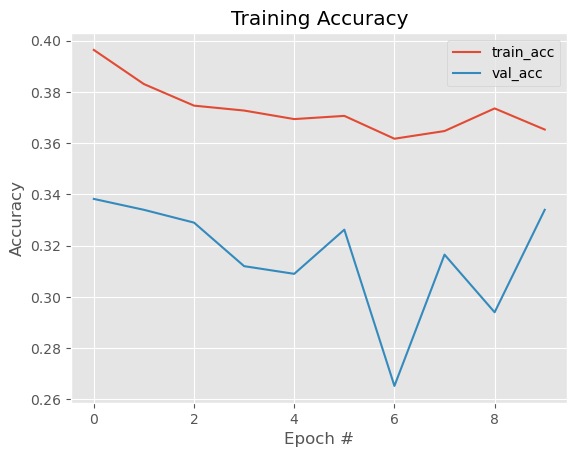

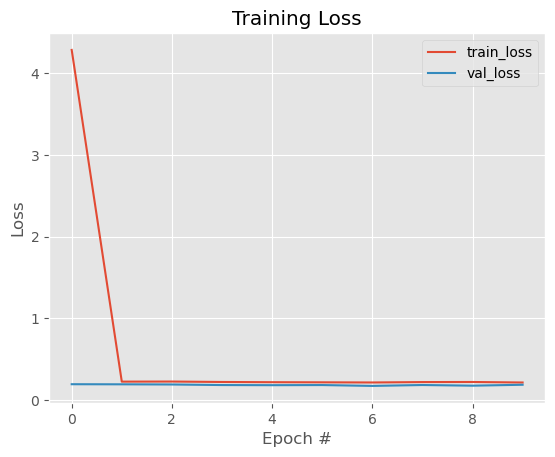

In [21]:
plot_training(history)

Predictions

In [22]:
predictions = model.predict([pairTest[:, 0], pairTest[:, 1]])

125/125 [==============================] - 63s 502ms/step


In [23]:
res = model.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

125/125 [==============================] - 64s 505ms/step - loss: 0.1799 - accuracy: 0.3115


In [24]:
print('accuracy:')
res[1]

accuracy:


0.31150001287460327